In [4]:
import sys
import importlib
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import pvlib as pv
import matplotlib.pyplot as plt
import scipy.ndimage.filters as filters
from distributed import LocalCluster, Client

In [5]:
%matplotlib inline

In [6]:
sys.path.append('/home/travis/python_code/letkf_forecasting/')
import letkf_forecasting as lf

In [7]:
import prepare_sat_data as prep

In [9]:
sensor_data = pd.read_hdf('/home/travis/python_code/letkf_forecasting/data/sensor_data.h5')
sensor_CI = pd.read_hdf('/home/travis/python_code/letkf_forecasting/data/sensor_CI.h5')
sensor_loc = pd.read_hdf('/home/travis/python_code/letkf_forecasting/data/sensor_loc.h5')

/home/travis/miniconda3/envs/py35Solar/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


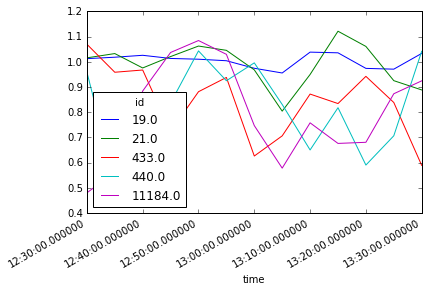

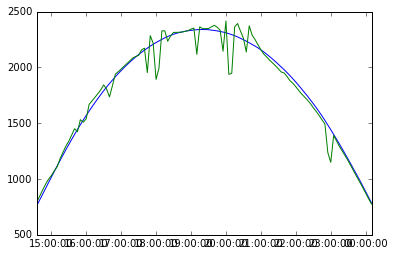

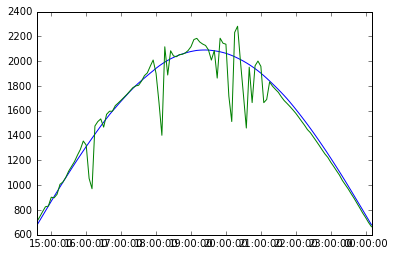

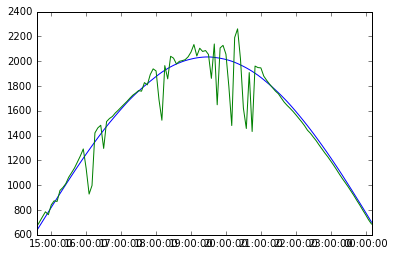

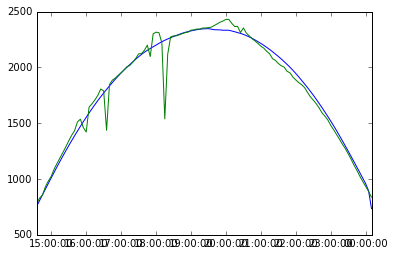

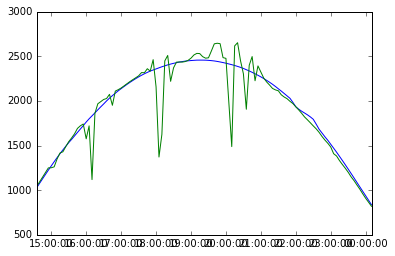

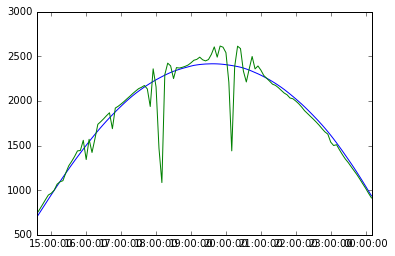

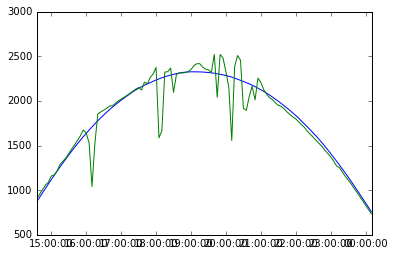

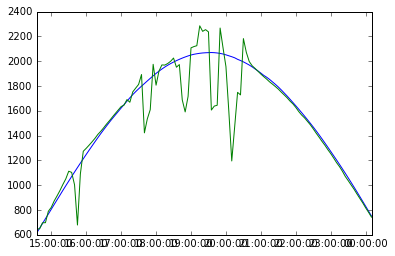

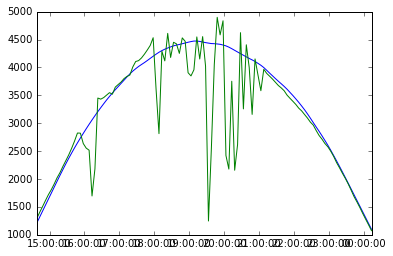

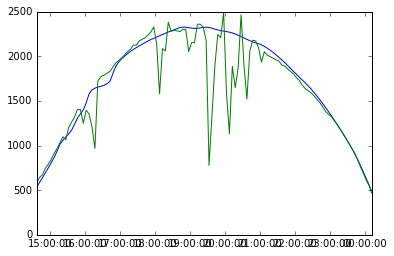

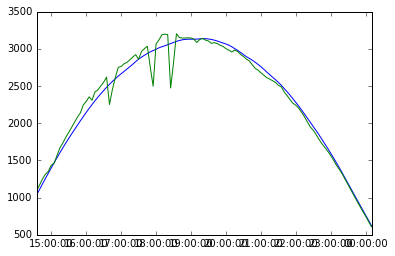

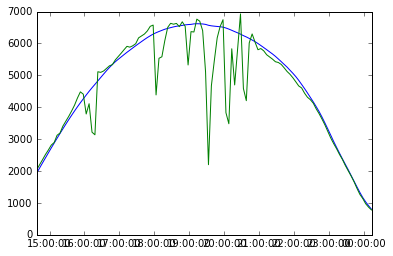

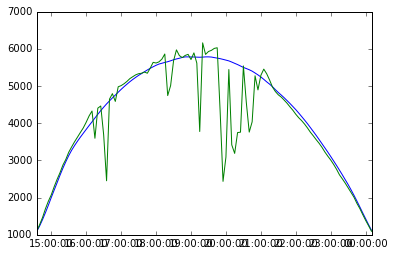

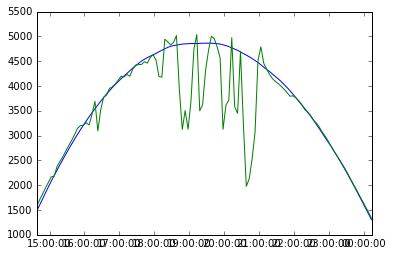

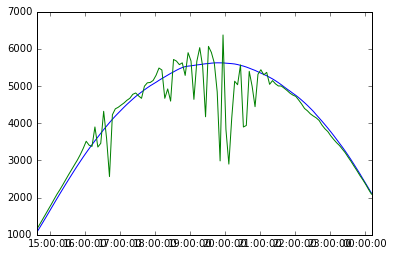

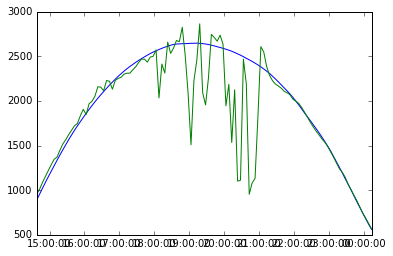

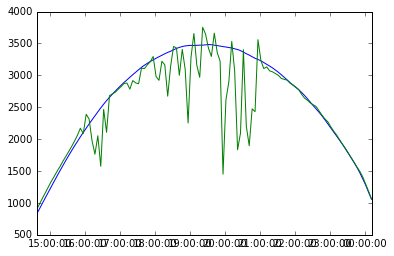

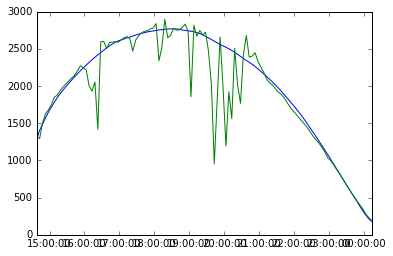

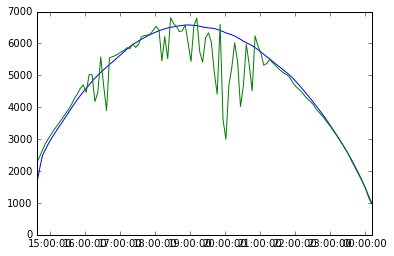

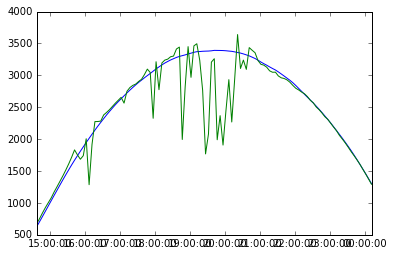

In [31]:
plt.figure()
sensor_CI[sensor_loc[sensor_loc.test==True].id].ix['2014-04-15 12:30' : '2014-04-15 13:30'].plot()

for i in sensor_loc[sensor_loc.test==False].id:
    plt.figure()
    plt.plot(sensor_data[sensor_data.id==i]['clearsky_profile'].ix['2014-04-15'])
    plt.plot(sensor_data[sensor_data.id==i]['ghi'].ix['2014-04-15'])

In [10]:
sensor_loc.sort_values(by='id', inplace=True)

In [24]:
cloudiness_14 = pd.read_hdf('./data/for_15/cloudiness_14.h5')
cloudiness_15 = pd.read_hdf('./data/for_15/cloudiness_15.h5')

corrected_cloudiness = (cloudiness_15 - cloudiness_14).clip(lower=0)
SUNY_coeff = np.array(np.array([2.36, -6.2, 6.22, -2.63, -0.58, 1]))
# cc_crop = corrected_cloudiness[flat_crop_indicies]
# cc_crop.columns = np.arange(flat_crop_indicies.size, dtype='int')

In [12]:
# csi_15 = pd.read_hdf('./data/for_15/csi_15.h5')
U_15 = pd.read_hdf('./data/for_15/U_fine.h5')
V_15 = pd.read_hdf('./data/for_15/V_fine.h5')
U_shape = np.load('./data/for_15/U_fine_shape.npy')
V_shape = np.load('./data/for_15/V_fine_shape.npy')

In [13]:
## filter winds
filter_len = 100*4
U_smooth = U_15.values.reshape(
    [U_15.shape[0], U_shape[0], U_shape[1]])
U_smooth = filters.uniform_filter(
    U_smooth, size=(0, filter_len, filter_len))
this_shape = U_smooth.shape
U_smooth = U_smooth.reshape(this_shape[0], this_shape[1]*this_shape[2])
U_smooth = pd.DataFrame(data=U_smooth, index=U_15.index)

V_smooth = V_15.values.reshape(
    [V_15.shape[0], V_shape[0], V_shape[1]])
V_smooth = filters.uniform_filter(
    V_smooth, size=(0, filter_len, filter_len))
this_shape = V_smooth.shape
V_smooth = V_smooth.reshape(this_shape[0], this_shape[1]*this_shape[2])
V_smooth = pd.DataFrame(data=V_smooth, index=V_15.index)

In [14]:
x_sat = np.load('./data/for_15/x_fine.npy')
y_sat = np.load('./data/for_15/y_fine.npy')
domain_shape = np.load('./data/for_15/fine_shape.npy')

In [15]:
x_range = x_sat.reshape(domain_shape)[0, :]
y_range = y_sat.reshape(domain_shape)[:, 0]

In [16]:
lon_sens = sensor_loc['lon'].values
lat_sens = sensor_loc['lat'].values

In [17]:
x_sens, y_sens = prep.sphere_to_lcc(lat_sens, lon_sens)
x_min = np.floor(x_sens.min())
x_max = np.ceil(x_sens.max())
y_min = np.floor(y_sens.min())
y_max = np.ceil(y_sens.max())
west_east_min = np.argmin(abs(x_min - x_range))
west_east_max = np.argmin(abs(x_max - x_range))
south_north_min = np.argmin(abs(y_min - y_range))
south_north_max = np.argmin(abs(y_max - y_range))

In [18]:
U_max = U_15.values.max() # know U is positive
V_max = abs(V_15.values.min()) # know V is negative

left = int(U_max*60*30/250) + 20
right = 20

up = int(V_max*60*30/250) + 20
down = 20

west_east_range = np.arange(west_east_min - left, west_east_max + right + 1, dtype='int')
west_east_range_stag = np.arange(west_east_min - left, west_east_max + right + 1 + 1, dtype='int')
south_north_range = np.arange(south_north_min - down, south_north_max + up + 1, dtype='int')
south_north_range_stag = np.arange(south_north_min - down, south_north_max + up + 1 + 1, dtype='int')
crop_shape = (south_north_range.size, west_east_range.size)
U_crop_shape = (south_north_range.size, west_east_range_stag.size)
V_crop_shape = (south_north_range_stag.size, west_east_range.size)
print('X length: ' + 
      str(west_east_range.size))
print('Y length: ' + 
      str(south_north_range.size))

X length: 438
Y length: 353


In [19]:
west_east_crop, south_north_crop = np.meshgrid(west_east_range, south_north_range)
crop_indicies_2d = np.array([south_north_crop.ravel(),
                             west_east_crop.ravel()])
flat_crop_indicies = np.ravel_multi_index(crop_indicies_2d,
                                          domain_shape)

In [20]:
west_east_crop_U, south_north_crop_U = np.meshgrid(west_east_range_stag, south_north_range)
crop_indicies_2d_U = np.array([south_north_crop_U.ravel(),
                               west_east_crop_U.ravel()])
flat_crop_indicies_U = np.ravel_multi_index(crop_indicies_2d_U,
                                            U_shape)

In [21]:
west_east_crop_V, south_north_crop_V = np.meshgrid(west_east_range, south_north_range_stag)
crop_indicies_2d_V = np.array([south_north_crop_V.ravel(),
                               west_east_crop_V.ravel()])
flat_crop_indicies_V = np.ravel_multi_index(crop_indicies_2d_V,
                                            V_shape)

In [22]:
x_crop = x_sat[flat_crop_indicies]
y_crop = y_sat[flat_crop_indicies]

In [23]:
n_workers = 20
cluster = LocalCluster(n_workers=n_workers, scheduler_port=7001, diagnostics_port=7002)
client = Client(cluster)

In [25]:
cci_crop = corrected_cloudiness[flat_crop_indicies]
cci_crop.columns = np.arange(flat_crop_indicies.size, dtype='int')
csi_crop = pd.DataFrame(data=np.polyval(SUNY_coeff, cci_crop),
                        index=cci_crop.index)

In [26]:
U_crop = U_smooth[flat_crop_indicies_U]
U_crop.columns = np.arange(flat_crop_indicies_U.size, dtype='int')
V_crop = V_smooth[flat_crop_indicies_V]
V_crop.columns = np.arange(flat_crop_indicies_V.size, dtype='int')

In [27]:
U_const = pd.DataFrame(data=np.ones_like(U_crop),
                       index=U_crop.index)*22.9
V_const = pd.DataFrame(data=np.ones_like(V_crop),
                       index=V_crop.index)*-2

In [ ]:
# Use actual satellite image as Truth to find error statistics
# forecast and analysis trace p
# Also do the same by converting cloudiness to csi and compare to sensor
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 0.7
assimilation_grid_size = 1 #was 5
localization_letkf = 1
sat_inflation = 1

goes15_azimuth = 220.5
goes15_elevation = 44.1

sat_sig = 0.00001 #0.01 #0.05 #0.001 <- good
ens_size = 40
wind_sigma = (.5, .5)
wind_size = 2

start_time = '2014-04-15 12:30:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:30:00' #Gets boring shortly after 14:00:00

analysis, background, advected, sat_time_range, trace_back, trace_analy = lf.main_only_sat(
    sat=csi_crop, x=x_crop, y=y_crop, domain_shape=crop_shape,                                                                                                                                                    
    U=U_crop, U_shape=U_crop_shape, V=V_crop, V_shape=V_crop_shape,                                                                                                                                                            
    start_time=start_time, end_time=end_time, dx=dx, dy=dy, C_max=C_max,                                                                                                                                               
    assimilation_grid_size=assimilation_grid_size,                                                                                                                                                            
    localization_letkf=localization_letkf, sat_inflation=sat_inflation,                                                                                                                                                
    sat_sig=sat_sig, ens_size=ens_size,                                                                                                                                                                 
    wind_sigma=wind_sigma, wind_size=wind_size,                                                                                                                                                             
    client=client)

In [ ]:
## OI and 15 min assimilation

# Use actual satellite image as Truth to find error statistics
# forecast and analysis trace p
# Also do the same by converting cloudiness to csi and compare to sensor
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 0.7
assimilation_grid_size = 200 # was 5
localization_letkf = 1
sat_inflation = 1
sensor_inflation = 1

sat_sig = 0.01 #0.01 #0.05 #0.001 <- good
sensor_sig = 0.01 #0.1 #0.05 #.1
ens_size = 20
wind_sigma = (1, 1)
wind_size = 2
CI_sigma = .4 # was .1

oi_localization = 0.6
oi_sensor_sig = .0088
oi_sat_sig = 5.5*10**-5
oi_inflation = 25000


start_time = '2014-04-15 12:30:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:45:00' #Gets boring shortly after 14:00:00

goes15_azimuth = 220.5
goes15_elevation = 44.1

tus = pv.location.Location(32.2, -111, 'US/Arizona', 700,'Tucson')

cloud_height = 8222

# U_corrected = U_crop.copy()
# V_corrected = V_crop.copy()
U_corrected = U_const.copy() - 3
V_corrected = V_const.copy()

stuff = lf.only_durring_sat(
    sat=csi_ci_crop, x=x_crop, y=y_crop, domain_shape=crop_shape,                                                                                                                                                    
    U=U_corrected, U_shape=U_crop_shape, V=V_corrected, V_shape=V_crop_shape,                                                                                                                                                            
    start_time=start_time, end_time=end_time, dx=dx, dy=dy, C_max=C_max,                                                                                                                                               
    assimilation_grid_size=assimilation_grid_size,                                                                                                                                                            
    localization_letkf=localization_letkf, sat_inflation=sat_inflation,                                                                                                                                                
    sat_sig=sat_sig, ens_size=ens_size,                                                                                                                                                                 
    wind_sigma=wind_sigma, wind_size=wind_size,                                                                                                                                                             
    client=client,
    oi_sensor_sig = oi_sensor_sig,
    oi_sat_sig = oi_sat_sig,
    oi_localization=oi_localization,
    oi_inflation=oi_inflation,
    sensor_data=sensor_CI,
    sensor_loc=sensor_loc,
    sensor_sig=sensor_sig,
    sensor_inflation=sensor_inflation,
    CI_sigma=CI_sigma, location=tus,
    cloud_height=cloud_height, sat_azimuth=goes15_azimuth,
    sat_elevation=goes15_elevation)
analysis, background, advected, used_sat, OI, sat_time_range, trace_back, trace_analy, background_error, analysis_error_sat, analysis_error_sat_sens, oi_error, sat_error = stuff

In [ ]:
plt.figure()
plt.plot(np.sqrt(background_error**2).mean(axis=1)[1:])
plt.plot(np.sqrt(sat_error**2).mean(axis=1)[1:])
plt.plot(np.sqrt(oi_error**2).mean(axis=1)[1:])
plt.plot(np.sqrt(analysis_error_sat**2).mean(axis=1)[1:])
plt.plot(np.sqrt(anlysis_error_sat_sens**2).mean(axis=1)[1:])
plt.legend(['back', 'sat', 'oi', 'sat_analy', 'both_analy'], loc='upper left')

In [ ]:
plt.figure()
plt.plot(np.sqrt(trace_back))
plt.plot(np.sqrt(trace_analy))
plt.legend(['back', 'analy'])
plt.title('Root of Trace P')

In [ ]:
shape = crop_shape

sn_start = 200
sn_size = 75 #75
sn_end = sn_start + sn_size
we_start = 45
we_size = sn_size
we_end = we_start + we_size
u_approx = U_corrected.ix[0, 0] #22.06
v_approx = V_corrected.ix[0, 0] #-.84
scaling = 15*60/250
we_step = int(round(u_approx*scaling))# - 6
sn_step = int(round(v_approx*scaling))

sn_crop = slice(None, None)
we_crop = slice(None, None)
for t in np.arange(sat_time_range.size):
    this_time = sat_time_range[t]
    
    vmin=0
    vmax=1

#     sn_crop = slice(sn_start, sn_end)
#     sn_start = sn_start + sn_step
#     sn_end = sn_end + sn_step
    
#     we_crop = slice(we_start, we_end)
#     we_start = we_start + we_step
#     we_end = we_end + we_step
    
#     vmin=None
#     vmax=None
    
#     plt.figure()
#     im = plt.pcolormesh(
# #         x_crop.reshape(shape)[sn_crop, we_crop],
# #         y_crop.reshape(shape)[sn_crop, we_crop],
#         background[t, 2:].reshape(shape)[sn_crop, we_crop],
#         cmap='Blues', vmin=vmin, vmax=vmax)
#     plt.colorbar(im)
#     plt.title('Background: ' + str(this_time))
#     plt.axis('equal')
    plt_x_min = x_crop.reshape(shape)[sn_crop, we_crop].min()
    plt_x_max = x_crop.reshape(shape)[sn_crop, we_crop].max()
    plt_y_min = y_crop.reshape(shape)[sn_crop, we_crop].min()
    plt_y_max = y_crop.reshape(shape)[sn_crop, we_crop].max()

    plt.figure()
    im = plt.pcolormesh(
        x_crop.reshape(shape)[sn_crop, we_crop],
        y_crop.reshape(shape)[sn_crop, we_crop],
        advected[t].reshape(shape)[sn_crop, we_crop],
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Advected: ' + str(this_time))
    plt.axis('equal')
    plt.gca().set_xlim((plt_x_min, plt_x_max))
    plt.gca().set_ylim((plt_y_min, plt_y_max))
    
    
    plt.figure()
    im = plt.pcolormesh(
        x_crop.reshape(shape)[sn_crop, we_crop],
        y_crop.reshape(shape)[sn_crop, we_crop],
        used_sat[t].reshape(shape)[sn_crop, we_crop],
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Sat: ' + str(this_time))
    plt.axis('equal')
    plt.gca().set_xlim((plt_x_min, plt_x_max))
    plt.gca().set_ylim((plt_y_min, plt_y_max))
    
#     plt.figure()
#     im = plt.pcolormesh(
#         x_crop.reshape(shape)[sn_crop, we_crop],
#         y_crop.reshape(shape)[sn_crop, we_crop],
#         (analysis[t, 2:]).reshape(shape)[sn_crop, we_crop],
#         cmap='Blues', vmin=vmin, vmax=vmax)
#     plt.colorbar(im)
#     plt.title('Analysis: ' + str(this_time))
#     plt.axis('equal')
#     plt.gca().set_xlim((plt_x_min, plt_x_max))
#     plt.gca().set_ylim((plt_y_min, plt_y_max))
    
    
#     plt.figure()
#     im = plt.pcolormesh(
# #         x_crop.reshape(shape)[sn_crop, we_crop],
# #         y_crop.reshape(shape)[sn_crop, we_crop],
#         OI[t].reshape(shape)[sn_crop, we_crop],
#         cmap='Blues', vmin=vmin, vmax=vmax)
#     plt.colorbar(im)
#     plt.title('OI: ' + str(this_time))
#     plt.axis('equal')

In [ ]:
shape = crop_shape

sn_start = 200
sn_size = 75 #75
sn_end = sn_start + sn_size
we_start = 45
we_size = sn_size
we_end = we_start + we_size
u_approx = U_corrected.ix[0, 0] #22.06
v_approx = V_corrected.ix[0, 0] #-.84
scaling = 15*60/250
we_step = int(round(u_approx*scaling))# - 6
sn_step = int(round(v_approx*scaling))

sn_crop = slice(None, None)
we_crop = slice(None, None)
for t in np.arange(sat_time_range.size):
    this_time = sat_time_range[t]
    
    vmin=0
    vmax=1.05

    sn_crop = slice(sn_start, sn_end)
    sn_start = sn_start + sn_step
    sn_end = sn_end + sn_step
    
    we_crop = slice(we_start, we_end)
    we_start = we_start + we_step
    we_end = we_end + we_step
    
#     vmin=None
#     vmax=None
    
    plt_x_min = x_crop.reshape(shape)[sn_crop, we_crop].min()
    plt_x_max = x_crop.reshape(shape)[sn_crop, we_crop].max()
    plt_y_min = y_crop.reshape(shape)[sn_crop, we_crop].min()
    plt_y_max = y_crop.reshape(shape)[sn_crop, we_crop].max()
    
#     plt.figure()
#     im = plt.pcolormesh(
# #         x_crop.reshape(shape)[sn_crop, we_crop],
# #         y_crop.reshape(shape)[sn_crop, we_crop],
#         background[t, 2:].reshape(shape)[sn_crop, we_crop],
#         cmap='Blues', vmin=vmin, vmax=vmax)
#     plt.colorbar(im)
#     plt.title('Background: ' + str(this_time))
#     plt.axis('equal')

    plt.figure()
    im = plt.pcolormesh(
        x_crop.reshape(shape)[sn_crop, we_crop],
        y_crop.reshape(shape)[sn_crop, we_crop],
        advected[t].reshape(shape)[sn_crop, we_crop],
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Advected: ' + str(this_time))
    plt.axis('equal')
    plt.gca().set_xlim((plt_x_min, plt_x_max))
    plt.gca().set_ylim((plt_y_min, plt_y_max))
    
    
    plt.figure()
    im = plt.pcolormesh(
        x_crop.reshape(shape)[sn_crop, we_crop],
        y_crop.reshape(shape)[sn_crop, we_crop],
        used_sat[t].reshape(shape)[sn_crop, we_crop],
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Sat: ' + str(this_time))
    plt.axis('equal')
    plt.gca().set_xlim((plt_x_min, plt_x_max))
    plt.gca().set_ylim((plt_y_min, plt_y_max))
    
#     plt.figure()
#     im = plt.pcolormesh(
#         x_crop.reshape(shape)[sn_crop, we_crop],
#         y_crop.reshape(shape)[sn_crop, we_crop],
#         (analysis[t, 2:]).reshape(shape)[sn_crop, we_crop],
#         cmap='Blues', vmin=vmin, vmax=vmax)
#     plt.colorbar(im)
#     plt.title('Analysis: ' + str(this_time))
#     plt.axis('equal')
#     plt.gca().set_xlim((plt_x_min, plt_x_max))
#     plt.gca().set_ylim((plt_y_min, plt_y_max))
    
    
#     plt.figure()
#     im = plt.pcolormesh(
# #         x_crop.reshape(shape)[sn_crop, we_crop],
# #         y_crop.reshape(shape)[sn_crop, we_crop],
#         OI[t].reshape(shape)[sn_crop, we_crop],
#         cmap='Blues', vmin=vmin, vmax=vmax)
#     plt.colorbar(im)
#     plt.title('OI: ' + str(this_time))
#     plt.axis('equal')

In [ ]:
shape = crop_shape

init_sn_start = 200 + 15
sn_size = 20  #75
init_sn_end = init_sn_start + sn_size

init_we_start = 45 + 15
we_size = sn_size
init_we_end = init_we_start + we_size

u_approx = U_corrected.ix[0, 0] #22.06
v_approx = V_corrected.ix[0, 0] #-.84

scaling = 15*60/250
# we_step = int(round(u_approx*scaling))# - 6
# sn_step = int(round(v_approx*scaling))

# sn_crop = slice(None, None)
# we_crop = slice(None, None)

for t in np.arange(sat_time_range.size):
    this_time = sat_time_range[t]
    
    vmin=0
    vmax=1.05
#     vmin=None
#     vmax=None

#     sn_crop = slice(sn_start, sn_end)
#     sn_start = sn_start + sn_step
#     sn_end = sn_end + sn_step
    sn_start = init_sn_start + int(round(v_approx*scaling*t))
    sn_end = init_sn_end + int(round(v_approx*scaling*t))
    sn_crop = slice(sn_start, sn_end)
    
    
#     we_crop = slice(we_start, we_end)
#     we_start = we_start + we_step
#     we_end = we_end + we_step
    we_start = init_we_start + int(round(u_approx*scaling*t))
    we_end = init_we_end + int(round(u_approx*scaling*t))
    we_crop = slice(we_start, we_end)
    
    plt_x_min = x_crop.reshape(shape)[sn_crop, we_crop].min()
    plt_x_max = x_crop.reshape(shape)[sn_crop, we_crop].max()
    plt_y_min = y_crop.reshape(shape)[sn_crop, we_crop].min()
    plt_y_max = y_crop.reshape(shape)[sn_crop, we_crop].max()
    
    tempx = np.arange(
        plt_x_min - .25/2, plt_x_max + .25/2 + .25, .25)
    tempy = np.arange(
        plt_y_min - .25/2, plt_y_max + .25/2 + .25, .25)
    this_x, this_y = np.meshgrid(tempx, tempy)
    
#     plt.figure()
#     im = plt.pcolormesh(
# #         x_crop.reshape(shape)[sn_crop, we_crop],
# #         y_crop.reshape(shape)[sn_crop, we_crop],
#         background[t, 2:].reshape(shape)[sn_crop, we_crop],
#         cmap='Blues', vmin=vmin, vmax=vmax)
#     plt.colorbar(im)
#     plt.title('Background: ' + str(this_time))
#     plt.axis('equal')

    fig1, (ax1)= plt.subplots(1, figsize=(10, 10))
    ax1.pcolormesh(
        this_x, this_y,
        advected[t].reshape(shape)[sn_crop, we_crop],
        cmap='Blues', vmin=vmin, vmax=vmax, shading='flat')
    for (i, j), label in np.ndenumerate(
            advected[t].reshape(shape)[sn_crop, we_crop]):
        label = np.round(label, decimals=2)
        x = this_x[i, j]
        y = this_y[i, j]
        ax1.text(x + .25/2, y + .25/2, label, ha='center', va='center')
    ax1.axis('equal') 
    plt.title('Advected: ' + str(this_time))
    plt.gca().set_xlim((plt_x_min - .25/2, plt_x_max + .25/2))
    plt.gca().set_ylim((plt_y_min - .25/2, plt_y_max + .25/2))
    plt.show()


#     plt.figure()
#     im = plt.pcolormesh(
#         x_crop.reshape(shape)[sn_crop, we_crop],
#         y_crop.reshape(shape)[sn_crop, we_crop],
#         advected[t].reshape(shape)[sn_crop, we_crop],
#         cmap='Blues', vmin=vmin, vmax=vmax, shading='flat')
#     plt.colorbar(im)
#     plt.title('Advected: ' + str(this_time))
#     plt.axis('equal')
#     plt.gca().set_xlim((plt_x_min, plt_x_max))
#     plt.gca().set_ylim((plt_y_min, plt_y_max))
    
    
#     plt.figure()
#     im = plt.pcolormesh(
#         x_crop.reshape(shape)[sn_crop, we_crop],
#         y_crop.reshape(shape)[sn_crop, we_crop],
#         used_sat[t].reshape(shape)[sn_crop, we_crop],
#         cmap='Blues', vmin=vmin, vmax=vmax, shading='flat')
#     plt.colorbar(im)
#     plt.title('Sat: ' + str(this_time))
#     plt.axis('equal')
#     plt.gca().set_xlim((plt_x_min, plt_x_max))
#     plt.gca().set_ylim((plt_y_min, plt_y_max))
    
    fig1, (ax1)= plt.subplots(1, figsize=(10, 10))
    ax1.pcolormesh(
        this_x, this_y,
        used_sat[t].reshape(shape)[sn_crop, we_crop],
        cmap='Blues', vmin=vmin, vmax=vmax, shading='flat')
    for (i, j), label in np.ndenumerate(
            used_sat[t].reshape(shape)[sn_crop, we_crop]):
        label = np.round(label, decimals=2)
        x = this_x[i, j]
        y = this_y[i, j]
        ax1.text(x + .25/2, y + .25/2, label, ha='center', va='center')
    ax1.axis('equal') 
    plt.title('Sat: ' + str(this_time))
    plt.gca().set_xlim((plt_x_min - .25/2, plt_x_max + .25/2))
    plt.gca().set_ylim((plt_y_min - .25/2, plt_y_max + .25/2))
    plt.show()  

In [ ]:
## only OI

# Use actual satellite image as Truth to find error statistics
# forecast and analysis trace p
# Also do the same by converting cloudiness to csi and compare to sensor
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 0.7
assimilation_grid_size = 1 # was 5
localization_letkf = 2
sat_inflation = 1
sensor_inflation = 1

sat_sig = 0.001 #0.01 #0.05 #0.001 <- good
sensor_sig = 0.01 #0.1 #0.05 #.1
ens_size = 40
wind_sigma = (.5, .5)
wind_size = 2
CI_sigma = .4 # was .1

oi_localization = 0.6
oi_sensor_sig = .0088
oi_sat_sig = 5.5*10**-5
oi_inflation = 2500


start_time = '2014-04-15 12:30:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:30:00' #Gets boring shortly after 14:00:00

goes15_azimuth = 220.5
goes15_elevation = 44.1

tus = pv.location.Location(32.2, -111, 'US/Arizona', 700,'Tucson')

cloud_height = 8222

stuff = lf.only_oi(
    sat=csi_crop, x=x_crop, y=y_crop, domain_shape=crop_shape,                                                                                                                                                                                                                                                                                                             
    start_time=start_time, end_time=end_time,
    oi_sensor_sig = oi_sensor_sig,
    oi_sat_sig = oi_sat_sig,
    oi_localization=oi_localization,
    oi_inflation=oi_inflation,
    sensor_data=sensor_CI,
    sensor_loc=sensor_loc,
    location=tus,
    cloud_height=cloud_height, sat_azimuth=goes15_azimuth,
    sat_elevation=goes15_elevation)
analysis, background, advected, used_sat, OI, sat_time_range, trace_back, trace_analy = stuff

In [ ]:
analysis_only_sat = analysis.copy()
background_only_sat = background.copy()
advected_only_sat = advected.copy()
sat_time_range_only_sat = sat_time_range.copy()

In [ ]:
plt.figure()
plt.plot(trace_back[1:])
plt.plot(trace_analy[1:])
plt.legend(['background', 'analysis'])

In [ ]:
#0.001
shape = crop_shape
for t in range(sat_time_range.size):
    this_time = sat_time_range[t]
    
    vmin=0
    vmax=1.2
    
    plt.figure()
    im = plt.pcolormesh(x_crop.reshape(shape), y_crop.reshape(shape),
        background[t, 2:].reshape(shape) ,
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Background: ' + str(this_time))
    plt.axis('equal')
    
#     plt.figure()
#     im = plt.pcolormesh(x_crop.reshape(shape), y_crop.reshape(shape),
#         advected[t].reshape(shape),
#         cmap='Blues', vmin=vmin, vmax=vmax)
#     plt.colorbar(im)
#     plt.title('advected: ' + str(this_time))
#     plt.axis('equal')
    
    plt.figure()
    im = plt.pcolormesh(x_crop.reshape(shape), y_crop.reshape(shape),
        (analysis[t, 2:]).reshape(shape),
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Analysis: ' + str(this_time))
    plt.axis('equal')

In [ ]:
# update SUNY coefficients

importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 0.7
assimilation_grid_size = 5 #was 5
localization = 2
sat_inflation = 1
sensor_inflation = 1.2

goes15_azimuth = 220.5
goes15_elevation = 44.1

sat_sig = 0.01 #0.01 #0.05
sensor_sig = 0.05 #0.1 #0.05
ens_size = 40
wind_sigma = (.5, .5)
wind_size = 2
CI_sigma = .0001
coeff_sigma = np.array([.3, .5])
SUNY_coeff = np.array(np.array([2.36, -6.2, 6.22, -2.63, -0.58, 1]))

tus = pv.location.Location(32.2, -111, 'US/Arizona', 700,'Tucson')

cloud_height = 8222

start_time = '2014-04-15 12:45:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:45:00' #Gets boring shortly after 14:00:00

analysis, analysis_error, background, background_error, advected, time_range, trace_back, trace_analy = lf.main(
    sat=cci_crop, x=x_crop, y=y_crop, domain_shape=crop_shape,                                                                                                                                                    
    U=U_crop, U_shape=U_crop_shape, V=V_crop, V_shape=V_crop_shape,                                                                                                                                                            
    start_time=start_time, end_time=end_time, dx=dx, dy=dy, C_max=C_max,                                                                                                                                               
    assimilation_grid_size=assimilation_grid_size,                                                                                                                                                            
    localization_letkf=localization_letkf, sat_inflation=sat_inflation,                                                                                                                                                
    sat_sig=sat_sig, ens_size=ens_size,                                                                                                                                                                 
    wind_sigma=wind_sigma, wind_size=wind_size,                                                                                                                                                             
    client=client,
    sensor_data=sensor_CI,
    sensor_loc=sensor_loc,
    sensor_sig=sensor_sig,
    sensor_inflation=sensor_inflation,
    CI_sigma=CI_sigma, coeff_sigma=coeff_sigma, location=tus,
    cloud_height=cloud_height, sat_azimuth=goes15_azimuth,
    sat_elevation=goes15_elevation)

In [ ]:
shape = crop_shape
for t in range(time_range.size):
    this_time = time_range[t]
    
    vmin=0
    vmax=1.05
    
#     vmin=None
#     vmax=None

    this_coeff_pert = np.array(
        [0,0,0,0, background[t, 1] - background[t, 0], background[t, 0]])
    this_background = np.polyval(SUNY_coeff + this_coeff_pert, background[t, 2 + 2:].reshape(shape))
    plt.figure()
    im = plt.pcolormesh(x_crop.reshape(shape), y_crop.reshape(shape),
        this_background,
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Background: ' + str(this_time))
    plt.axis('equal')
    
#     plt.figure()
#     im = plt.pcolormesh(x_crop.reshape(shape), y_crop.reshape(shape),
#         advected[t].reshape(shape),
#         cmap='Blues', vmin=vmin, vmax=vmax)
#     plt.colorbar(im)
#     plt.title('advected: ' + str(this_time))
#     plt.axis('equal')
    
    this_coeff_pert = np.array(
        [0,0,0,0, analysis[t, 1] - analysis[t, 0], analysis[t, 0]])
    this_analysis = np.polyval(SUNY_coeff + this_coeff_pert, analysis[t, 2 + 2:].reshape(shape))
    plt.figure()
    im = plt.pcolormesh(x_crop.reshape(shape), y_crop.reshape(shape),
        this_analysis,
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Analysis: ' + str(this_time))
    plt.axis('equal')
    
#     plt.figure()
#     im = plt.pcolormesh(x_crop.reshape(shape), y_crop.reshape(shape),
#         this_analysis-this_background,
#         cmap='Blues', vmin=vmin, vmax=vmax)
#     plt.colorbar(im)
#     plt.title('Analysis: ' + str(this_time))
#     plt.axis('equal')

In [ ]:
plt.figure()
plt.plot(np.sqrt(trace_back[1:]))
plt.plot(np.sqrt(trace_analy[1:]))
plt.legend(['background', 'analysis'])

In [ ]:
analysis_rmse = np.sqrt((analysis_error**2).mean(axis=1))
background_rmse = np.sqrt((background_error**2).mean(axis=1))
plt.figure()
plt.plot(background_rmse[1:])
plt.plot(analysis_rmse[1:])
plt.legend(['background', 'analysis'])

In [ ]:
plt.figure()
plt.plot(analysis_error)

In [ ]:
plt.figure()
plt.plot(np.sqrt((background_error**2).mean(axis=1))[1:])
plt.plot(np.sqrt((analysis_error**2).mean(axis=1))[1:])
plt.legend(['background', 'analysis'])

In [ ]:
from functools import partial

In [ ]:
start_time = '2014-04-15 12:30:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:30:00' #Gets boring shortly after 14:00:00

assimilation_grid_size = 5


short_fun_d = partial(lf.main,
    sat=sat_15.isel(west_east=x_crop, south_north=y_crop),
    wind=wind_15_smooth.isel(west_east=x_crop, west_east_stag=x_crop_stag,
                             south_north=y_crop, south_north_stag=y_crop_stag),
    sensor_data=sensor_CI,
    sensor_loc=sensor_loc,
    start_time=start_time, end_time=end_time, dx=dx, dy=dy,
    C_max=C_max,
    assimilation_grid_size=assimilation_grid_size,
    localization_length=localization, inflation=inflation,
    sat_sig=sat_sig, sensor_sig=sensor_sig, ens_size=ens_size,
    wind_sigma=wind_sigma, wind_size=wind_size, CI_sigma=CI_sigma,
    location=tus, cloud_height=cloud_height, sat_azimuth=goes15_azimuth,
    sat_elevation=goes15_elevation, client=client)

In [ ]:
%lprun -f lf.main short_fun_d()

In [ ]:
np.arange(16).reshape(4,4).mean()

In [ ]:
# Minimize error from wind error # not the best
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 0.7

start_time = '2014-04-15 12:30:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:30:00' #Gets boring shortly after 14:00:00

u_pert = 1
v_pert = 0

x_crop_stag = slice(x_crop.start - 1, x_crop.stop)
y_crop_stag = slice(y_crop.start - 1, y_crop.stop)

for u_pert in np.linspace(-5, 5, 10):
    for v_pert in np.linspace(-2, 2, 5):
        print('u_pert: ' + str(u_pert))
        print('v_pert: ' + str(v_pert))
        lf.just_advection(
            sat=sat_15.isel(west_east=x_crop, south_north=y_crop),
            wind=wind_15_smooth.isel(west_east=x_crop, west_east_stag=x_crop_stag,
                                     south_north=y_crop, south_north_stag=y_crop_stag),
            u_pert=u_pert, v_pert=v_pert,
            start_time=start_time, end_time=end_time, dx=dx, dy=dy,
            C_max=C_max)